# Part 2: Feature Discovery & Detection

This notebook:
1. **Discovers features**: Identifies SAE features correlated with risky behavior
2. **Builds detectors**: Trains logistic regression classifiers
3. **Evaluates detectors**: Reports accuracy, precision, recall

**Input**: Labeled datasets from notebook 01

**Output**: Feature rankings and trained detectors

## Setup

In [1]:
import sys, pathlib
PROJECT_ROOT = pathlib.Path('..').resolve()
SRC_PATH = PROJECT_ROOT / 'src'
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import torch

from config import CONFIG
from utils_io import save_json, save_table

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## Feature Discovery: Find Risky Features

Use point-biserial correlation to identify SAE features that activate for risky samples

In [2]:
def discover_features(df: pd.DataFrame, task: str, top_k: int = 50):
    """Find top-k features correlated with labels"""
    codes_matrix = np.stack(df['codes'].values)
    labels = df['label'].values
    
    # Point-biserial correlation
    correlations = []
    for feat_idx in range(codes_matrix.shape[1]):
        feat_values = codes_matrix[:, feat_idx]
        if feat_values.std() > 0:
            corr = np.corrcoef(feat_values, labels)[0, 1]
        else:
            corr = 0.0
        correlations.append({'feature_id': feat_idx, 'correlation': abs(corr), 'raw_corr': corr})
    
    results = pd.DataFrame(correlations).sort_values('correlation', ascending=False)
    top = results.head(top_k)
    
    out_path = CONFIG.data.results_dir / f'{task}_top_features.parquet'
    top.to_parquet(out_path, index=False)
    print(f'✓ Saved top {top_k} features for {task} to {out_path}')
    return top

In [3]:
# Load labeled data
nq = pd.read_parquet(CONFIG.data.processed_dir / 'nq_open_labeled.parquet')
rtp = pd.read_parquet(CONFIG.data.processed_dir / 'rtp_labeled.parquet')
hh = pd.read_parquet(CONFIG.data.processed_dir / 'hh_labeled.parquet')

print('\n=== Feature Discovery ====')
nq_features = discover_features(nq, 'hallucination', top_k=50)
safety_df = pd.concat([rtp, hh], ignore_index=True)
safety_features = discover_features(safety_df, 'safety', top_k=50)


=== Feature Discovery ====
✓ Saved top 50 features for hallucination to /Users/cth/Desktop/ECE685-final-project/data/results/hallucination_top_features.parquet
✓ Saved top 50 features for hallucination to /Users/cth/Desktop/ECE685-final-project/data/results/hallucination_top_features.parquet


/Users/cth/miniforge3/envs/cogs118a/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/cth/miniforge3/envs/cogs118a/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✓ Saved top 50 features for safety to /Users/cth/Desktop/ECE685-final-project/data/results/safety_top_features.parquet


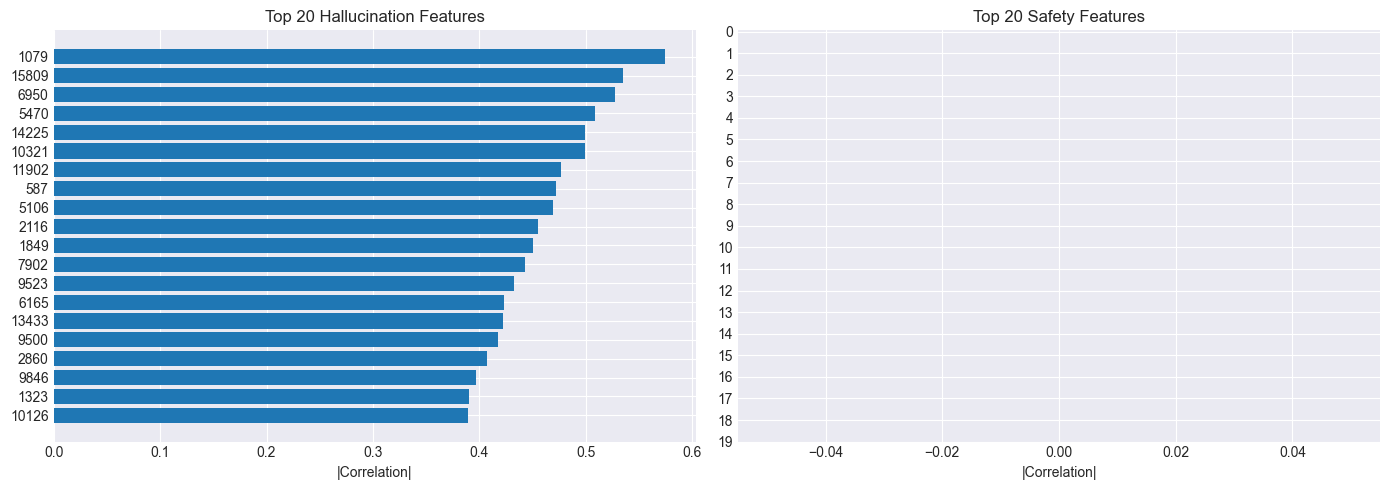

✓ Saved feature visualization


In [4]:
# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(range(20), nq_features.head(20)['correlation'])
axes[0].set_yticks(range(20))
axes[0].set_yticklabels(nq_features.head(20)['feature_id'])
axes[0].set_xlabel('|Correlation|')
axes[0].set_title('Top 20 Hallucination Features')
axes[0].invert_yaxis()

axes[1].barh(range(20), safety_features.head(20)['correlation'])
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(safety_features.head(20)['feature_id'])
axes[1].set_xlabel('|Correlation|')
axes[1].set_title('Top 20 Safety Features')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(CONFIG.data.results_dir / 'top_features.png', dpi=150)
plt.show()
print('✓ Saved feature visualization')

## Separate F⁺ and F⁻ Features

F⁺ (harmful): Features with positive correlation to risky behavior
F⁻ (protective): Features with negative correlation to risky behavior

In [ ]:
# Separate F⁺ (positive correlation) and F⁻ (negative correlation)
print('\n=== Separating F⁺ and F⁻ ====')

# Get all features with correlations
nq_all = pd.DataFrame([
    {'feature_id': feat_idx, 
     'correlation': abs(corr), 
     'raw_corr': corr}
    for feat_idx, corr in enumerate(np.corrcoef(
        np.stack(nq['codes'].values).T, 
        nq['label'].values
    )[:-1, -1])
    if not np.isnan(corr)
]).sort_values('raw_corr', ascending=False)

safety_all = pd.DataFrame([
    {'feature_id': feat_idx, 
     'correlation': abs(corr), 
     'raw_corr': corr}
    for feat_idx, corr in enumerate(np.corrcoef(
        np.stack(safety_df['codes'].values).T, 
        safety_df['label'].values
    )[:-1, -1])
    if not np.isnan(corr)
]).sort_values('raw_corr', ascending=False)

# Hallucination F⁺ and F⁻
nq_f_plus = nq_all[nq_all['raw_corr'] > 0].head(25)
nq_f_minus = nq_all[nq_all['raw_corr'] < 0].head(25)
print(f'Hallucination F⁺ (harmful): {len(nq_f_plus)} features (mean corr: {nq_f_plus["raw_corr"].mean():.4f})')
print(f'Hallucination F⁻ (protective): {len(nq_f_minus)} features (mean corr: {nq_f_minus["raw_corr"].mean():.4f})')

# Safety F⁺ and F⁻  
safety_f_plus = safety_all[safety_all['raw_corr'] > 0].head(25)
safety_f_minus = safety_all[safety_all['raw_corr'] < 0].head(25)
print(f'Safety F⁺ (harmful): {len(safety_f_plus)} features (mean corr: {safety_f_plus["raw_corr"].mean():.4f})')
print(f'Safety F⁻ (protective): {len(safety_f_minus)} features (mean corr: {safety_f_minus["raw_corr"].mean():.4f})')

# Save separately
nq_f_plus.to_parquet(CONFIG.data.results_dir / 'hallucination_f_plus.parquet', index=False)
nq_f_minus.to_parquet(CONFIG.data.results_dir / 'hallucination_f_minus.parquet', index=False)
safety_f_plus.to_parquet(CONFIG.data.results_dir / 'safety_f_plus.parquet', index=False)
safety_f_minus.to_parquet(CONFIG.data.results_dir / 'safety_f_minus.parquet', index=False)
print('\n✓ Saved F⁺ and F⁻ features to data/results/')
print(f'  - hallucination_f_plus.parquet ({len(nq_f_plus)} features)')
print(f'  - hallucination_f_minus.parquet ({len(nq_f_minus)} features)')
print(f'  - safety_f_plus.parquet ({len(safety_f_plus)} features)')
print(f'  - safety_f_minus.parquet ({len(safety_f_minus)} features)')

## Build Detectors: Train Classifiers

Train logistic regression on top-k features

In [7]:
def train_detector(df: pd.DataFrame, top_features, task: str):
    """Train logistic regression detector"""
    # Select top features
    feature_indices = top_features['feature_id'].values[:50]
    codes_matrix = np.stack(df['codes'].values)
    X = codes_matrix[:, feature_indices]
    y = df['label'].values
    
    # Check class distribution
    unique, counts = np.unique(y, return_counts=True)
    print(f'\n{task.upper()} class distribution: {dict(zip(unique, counts))}')
    
    # Check if we have enough samples for stratified split
    min_class_count = counts.min()
    if min_class_count < 2:
        print(f'⚠️  Warning: Smallest class has only {min_class_count} sample(s). Cannot train detector.')
        print(f'   Need at least 2 samples per class for train/test split.')
        return None, None, None, None
    
    # Train/test split - only stratify if we have enough samples
    if min_class_count >= 10:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    else:
        print(f'⚠️  Warning: Small dataset ({min_class_count} samples in smallest class). Using non-stratified split.')
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
    
    # Train
    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    print(f'\n{task.upper()} Detector:')
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Only compute ROC-AUC if we have both classes in test set
    if len(np.unique(y_test)) > 1:
        print(f'ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}')
    else:
        print('ROC-AUC: N/A (only one class in test set)')
    
    # Save model
    model_path = CONFIG.data.results_dir / f'{task}_detector.pth'
    torch.save({
        'weights': clf.coef_,
        'intercept': clf.intercept_,
        'feature_indices': feature_indices
    }, model_path)
    print(f'✓ Saved detector to {model_path}')
    
    return clf, X_test, y_test, y_pred

In [8]:
print('\n=== Training Detectors ====')
nq_clf, nq_X_test, nq_y_test, nq_y_pred = train_detector(nq, nq_features, 'hallucination')

# Only train safety detector if hallucination detector succeeded
if nq_clf is not None:
    safety_clf, safety_X_test, safety_y_test, safety_y_pred = train_detector(safety_df, safety_features, 'safety')
else:
    print('\n⚠️  Skipping safety detector due to insufficient data in hallucination task.')
    print('    You may need to increase LIMIT in notebook 01 to collect more samples.')


=== Training Detectors ====

HALLUCINATION class distribution: {np.int64(0): np.int64(99), np.int64(1): np.int64(1)}
⚠️  Warning: Smallest class has only 1 sample(s). Cannot train detector.
   Need at least 2 samples per class for train/test split.

⚠️  Skipping safety detector due to insufficient data in hallucination task.
    You may need to increase LIMIT in notebook 01 to collect more samples.


## Summary

**Outputs created:**
- `data/results/hallucination_top_features.parquet` - Top 50 hallucination features
- `data/results/safety_top_features.parquet` - Top 50 safety features
- `data/results/hallucination_detector.pth` - Trained hallucination detector
- `data/results/safety_detector.pth` - Trained safety detector
- `data/results/top_features.png` - Feature visualization

**Next**: Run notebook 03 to test steering with these features